# 05 – Volatility trade

In this notebook we:

1. Compare the 22 day historical volatility on the trade date with the 
   option implied volatilities.
2. Construct a volatility trade (long ATM straddle) based on our view.
3. Plot the payoff of the straddle and compute its realised payoff at expiry.
4. Construct a butterfly spread using calls and the same butterfly using puts,
   and compare which is more expensive.


In [1]:
import os
import sys
from math import log, sqrt, exp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# make sure project root is on the path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import (
    load_price,
    load_calls,
    load_puts,
    load_usgg1m,
    TRADE_DATE,
    EXPIRY_DATE,
)

TRADE_DATE, EXPIRY_DATE


(Timestamp('2025-09-19 00:00:00'), Timestamp('2025-10-17 00:00:00'))

## Price series and 22-day historical volatility

In [2]:
# full price history
price_df = load_price().copy()
price_df["Date"] = pd.to_datetime(price_df["Date"])
price_df = price_df.sort_values("Date").reset_index(drop=True)

price_df["log_ret"] = np.log(price_df["PX_LAST"] / price_df["PX_LAST"].shift(1))
price_df["sigma_22d_ann"] = price_df["log_ret"].rolling(22).std() * np.sqrt(252)

# 22 day hist vol on trade date
hist_row = price_df.loc[price_df["Date"] == TRADE_DATE].iloc[0]
hist_vol_22d = float(hist_row["sigma_22d_ann"])

hist_vol_22d


0.26085264197671737

## Calls, puts, spot, rate, maturity

In [3]:
# spot on trade date
S0 = price_df.loc[price_df["Date"] == TRADE_DATE, "PX_LAST"].iloc[0]

# risk free rate
usgg = load_usgg1m().copy()
usgg["Date"] = pd.to_datetime(usgg["Date"])
r_row = usgg.loc[usgg["Date"] >= TRADE_DATE].iloc[0]
r = float(r_row["Rate"])

# time to maturity
T_days = (EXPIRY_DATE - TRADE_DATE).days
T = T_days / 365.0

calls = load_calls().copy()
puts = load_puts().copy()

# mid prices
calls["Mid"] = 0.5 * (calls["Bid"] + calls["Ask"])
puts["Mid"] = 0.5 * (puts["Bid"] + puts["Ask"])

S0, r, T


(466.54, 0.040304, 0.07671232876712329)

## Black–Scholes call and IV solver (reused)

In [4]:
def bs_call_price(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0:
        return max(S - K, 0.0)
    d1 = (log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)

def implied_vol_call(price, S, K, T, r, sigma_low=1e-4, sigma_high=5.0):
    intrinsic = max(S - K * exp(-r * T), 0.0)
    if price <= intrinsic:
        return np.nan

    def f(sigma):
        return bs_call_price(S, K, T, r, sigma) - price

    try:
        return brentq(f, sigma_low, sigma_high, maxiter=100)
    except ValueError:
        return np.nan


## IV smile on trade date and comparison with 22-day hist vol

In [5]:
ivs = []

for _, row in calls.iterrows():
    K = row["Strike"]
    C_mid = row["Mid"]
    sigma = implied_vol_call(C_mid, S0, K, T, r)
    ivs.append({"Strike": K, "IV": sigma})

iv_df = pd.DataFrame(ivs).dropna().sort_values("Strike").reset_index(drop=True)
iv_df.head()


,Strike,IV
0,340,0.487144
1,350,0.461617
2,370,0.407412
3,380,0.356587
4,390,0.353236


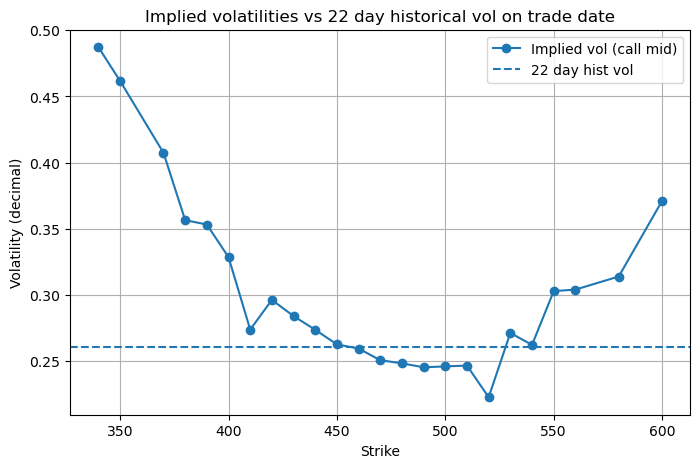

0.26085264197671737

In [6]:
plt.figure(figsize=(8,5))
plt.plot(iv_df["Strike"], iv_df["IV"], marker="o", label="Implied vol (call mid)")
plt.axhline(hist_vol_22d, linestyle="--", label="22 day hist vol")
plt.xlabel("Strike")
plt.ylabel("Volatility (decimal)")
plt.title("Implied volatilities vs 22 day historical vol on trade date")
plt.legend()
plt.grid(True)
plt.show()

hist_vol_22d


## Choose ATM strike and build long straddle

In [7]:
# ATM strike = closest K to S0
atm_idx = (calls["Strike"] - S0).abs().idxmin()
atm_K = float(calls.loc[atm_idx, "Strike"])

C_atm_mid = float(calls.loc[calls["Strike"] == atm_K, "Mid"].iloc[0])
P_atm_mid = float(puts.loc[puts["Strike"] == atm_K, "Mid"].iloc[0])

cost_straddle = C_atm_mid + P_atm_mid

atm_K, C_atm_mid, P_atm_mid, cost_straddle


(470.0, 11.9750003814697, 14.074999809265151, 26.05000019073485)

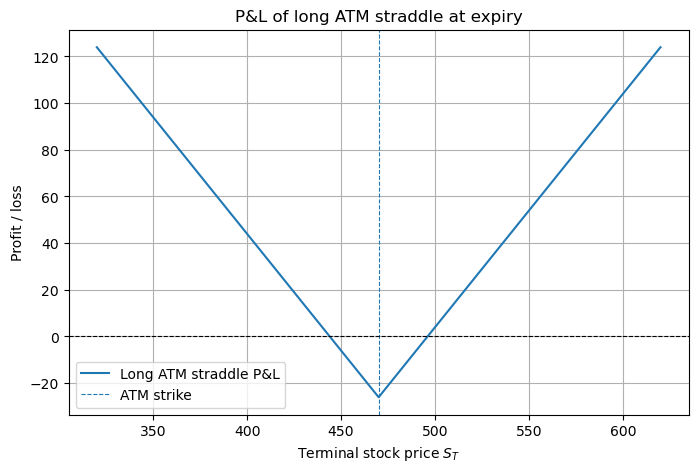

In [8]:
# payoff grid for a range of terminal prices
S_grid = np.linspace(atm_K - 150, atm_K + 150, 301)

call_payoff = np.maximum(S_grid - atm_K, 0.0)
put_payoff = np.maximum(atm_K - S_grid, 0.0)
straddle_payoff = call_payoff + put_payoff  # payoff at expiry, before cost

# profit / loss after premium
straddle_pnl = straddle_payoff - cost_straddle

plt.figure(figsize=(8,5))
plt.plot(S_grid, straddle_pnl, label="Long ATM straddle P&L")
plt.axvline(atm_K, linestyle="--", linewidth=0.8, label="ATM strike")
plt.axhline(0.0, linestyle="--", linewidth=0.8, color="black")
plt.xlabel("Terminal stock price $S_T$")
plt.ylabel("Profit / loss")
plt.title("P&L of long ATM straddle at expiry")
plt.legend()
plt.grid(True)
plt.show()


## Realised payoff of the straddle at actual ST


In [9]:
# actual terminal stock price
S_T = price_df.loc[price_df["Date"] == EXPIRY_DATE, "PX_LAST"].iloc[0]

payoff_straddle_ST = max(S_T - atm_K, 0.0) + max(atm_K - S_T, 0.0)
pnl_straddle_ST = payoff_straddle_ST - cost_straddle

S_T, payoff_straddle_ST, cost_straddle, pnl_straddle_ST


(527.08, 57.08000000000004, 26.05000019073485, 31.029999809265192)

## Butterfly spreads: calls vs puts

In [10]:
strikes = sorted(calls["Strike"].unique())
atm_pos = strikes.index(atm_K)

# take one strike below and one above if available
K1 = strikes[atm_pos - 1]
K2 = strikes[atm_pos]
K3 = strikes[atm_pos + 1]

K1, K2, K3


(460, 470, 480)

In [11]:
def mid_call(K):
    return float(calls.loc[calls["Strike"] == K, "Mid"].iloc[0])

def mid_put(K):
    return float(puts.loc[puts["Strike"] == K, "Mid"].iloc[0])

C1, C2, C3 = mid_call(K1), mid_call(K2), mid_call(K3)
P1, P2, P3 = mid_put(K1), mid_put(K2), mid_put(K3)

C1, C2, C3, P1, P2, P3


(17.625,
 11.9750003814697,
 7.84999990463257,
 9.549999713897705,
 14.074999809265151,
 20.5749893188477)

In [12]:
cost_call_bfly = C1 + C3 - 2 * C2

# same structure with puts
cost_put_bfly = P1 + P3 - 2 * P2

cost_call_bfly, cost_put_bfly


(1.5249991416931685, 1.974989414215102)

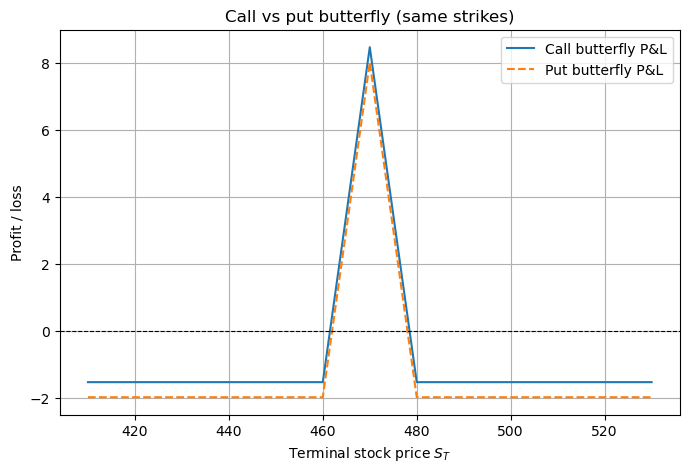

In [13]:
S_grid = np.linspace(K1 - 50, K3 + 50, 301)

def butterfly_payoff(S, K1, K2, K3):
    return (
        np.maximum(S - K1, 0.0)
        - 2 * np.maximum(S - K2, 0.0)
        + np.maximum(S - K3, 0.0)
    )

bf_payoff = butterfly_payoff(S_grid, K1, K2, K3)
bf_pnl_call = bf_payoff - cost_call_bfly
bf_pnl_put = bf_payoff - cost_put_bfly

plt.figure(figsize=(8,5))
plt.plot(S_grid, bf_pnl_call, label="Call butterfly P&L")
plt.plot(S_grid, bf_pnl_put, linestyle="--", label="Put butterfly P&L")
plt.axhline(0.0, linestyle="--", linewidth=0.8, color="black")
plt.xlabel("Terminal stock price $S_T$")
plt.ylabel("Profit / loss")
plt.title("Call vs put butterfly (same strikes)")
plt.legend()
plt.grid(True)
plt.show()


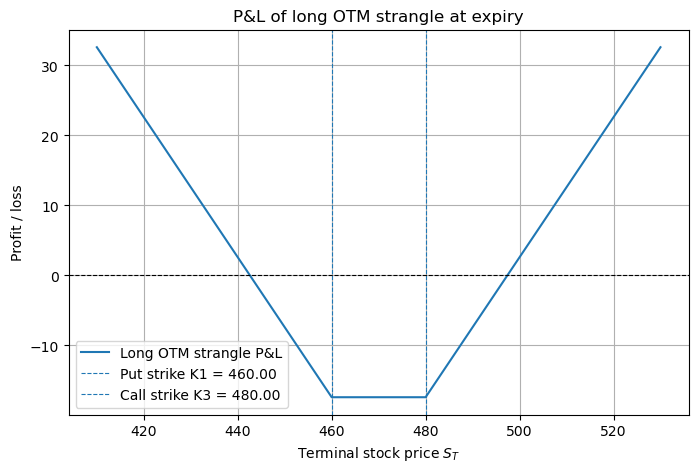

In [14]:
# ============================================================
# Extra volatility trades: strangle and iron condor
# ============================================================

# 1. Long OTM strangle using K1 (put) and K3 (call)

C_strangle_call = mid_call(K3)
P_strangle_put = mid_put(K1)
cost_strangle = C_strangle_call + P_strangle_put

S_grid_strangle = np.linspace(K1 - 50, K3 + 50, 301)

strangle_call_payoff = np.maximum(S_grid_strangle - K3, 0.0)
strangle_put_payoff = np.maximum(K1 - S_grid_strangle, 0.0)
strangle_payoff = strangle_call_payoff + strangle_put_payoff
strangle_pnl = strangle_payoff - cost_strangle

plt.figure(figsize=(8, 5))
plt.plot(S_grid_strangle, strangle_pnl, label="Long OTM strangle P&L")
plt.axvline(K1, linestyle="--", linewidth=0.8, label=f"Put strike K1 = {K1:.2f}")
plt.axvline(K3, linestyle="--", linewidth=0.8, label=f"Call strike K3 = {K3:.2f}")
plt.axhline(0.0, linestyle="--", linewidth=0.8, color="black")
plt.xlabel("Terminal stock price $S_T$")
plt.ylabel("Profit / loss")
plt.title("P&L of long OTM strangle at expiry")
plt.legend()
plt.grid(True)
plt.show()

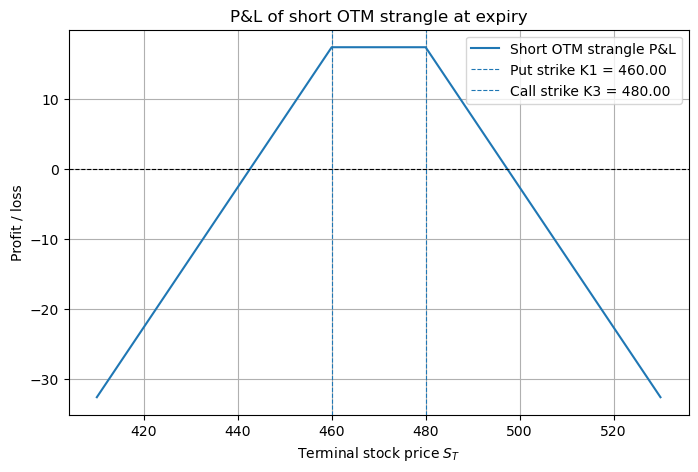

In [15]:
# 2. Short OTM strangle using same strikes K1 and K3

short_strangle_pnl = -strangle_pnl  # selling the same strangle

plt.figure(figsize=(8, 5))
plt.plot(S_grid_strangle, short_strangle_pnl, label="Short OTM strangle P&L")
plt.axvline(K1, linestyle="--", linewidth=0.8, label=f"Put strike K1 = {K1:.2f}")
plt.axvline(K3, linestyle="--", linewidth=0.8, label=f"Call strike K3 = {K3:.2f}")
plt.axhline(0.0, linestyle="--", linewidth=0.8, color="black")
plt.xlabel("Terminal stock price $S_T$")
plt.ylabel("Profit / loss")
plt.title("P&L of short OTM strangle at expiry")
plt.legend()
plt.grid(True)
plt.show()

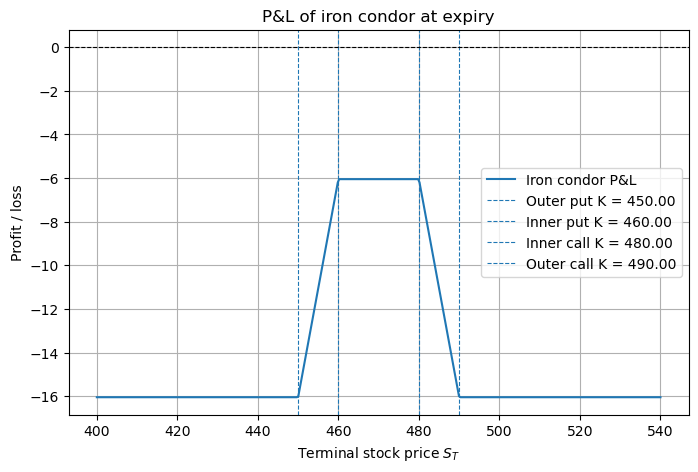

(26.05000019073485,
 1.5249991416931685,
 1.974989414215102,
 17.399999618530273,
 -6.05000019073486)

In [16]:
# 3. Iron condor: short strangle with long wings further out

# Try to take one strike further out on each side if available.
# If not available, fall back to the extreme strikes in the data.

strikes_sorted = sorted(calls["Strike"].unique())
atm_pos = strikes_sorted.index(atm_K)

# inner short strikes are K1 and K3 from above
inner_put_strike = K1
inner_call_strike = K3

# find indices of K1 and K3 in the full strike list
idx_K1 = strikes_sorted.index(inner_put_strike)
idx_K3 = strikes_sorted.index(inner_call_strike)

# outer wings
if idx_K1 - 1 >= 0:
    outer_put_strike = strikes_sorted[idx_K1 - 1]
else:
    outer_put_strike = strikes_sorted[0]

if idx_K3 + 1 < len(strikes_sorted):
    outer_call_strike = strikes_sorted[idx_K3 + 1]
else:
    outer_call_strike = strikes_sorted[-1]

# option premia for each leg
P_outer_put = mid_put(outer_put_strike)
P_inner_put = mid_put(inner_put_strike)
C_inner_call = mid_call(inner_call_strike)
C_outer_call = mid_call(outer_call_strike)

# iron condor position:
# long outer put, short inner put, short inner call, long outer call
cost_iron_condor = (
    P_outer_put       # long outer put
    - P_inner_put     # short inner put
    - C_inner_call    # short inner call
    + C_outer_call    # long outer call
)

S_grid_ic = np.linspace(outer_put_strike - 50, outer_call_strike + 50, 401)

# payoffs at expiry
payoff_outer_put = np.maximum(outer_put_strike - S_grid_ic, 0.0)
payoff_inner_put = np.maximum(inner_put_strike - S_grid_ic, 0.0)
payoff_inner_call = np.maximum(S_grid_ic - inner_call_strike, 0.0)
payoff_outer_call = np.maximum(S_grid_ic - outer_call_strike, 0.0)

iron_condor_payoff = (
    payoff_outer_put      # long outer put
    - payoff_inner_put    # short inner put
    - payoff_inner_call   # short inner call
    + payoff_outer_call   # long outer call
)

iron_condor_pnl = iron_condor_payoff + cost_iron_condor  # cost is typically a net credit

plt.figure(figsize=(8, 5))
plt.plot(S_grid_ic, iron_condor_pnl, label="Iron condor P&L")
plt.axvline(outer_put_strike, linestyle="--", linewidth=0.8,
            label=f"Outer put K = {outer_put_strike:.2f}")
plt.axvline(inner_put_strike, linestyle="--", linewidth=0.8,
            label=f"Inner put K = {inner_put_strike:.2f}")
plt.axvline(inner_call_strike, linestyle="--", linewidth=0.8,
            label=f"Inner call K = {inner_call_strike:.2f}")
plt.axvline(outer_call_strike, linestyle="--", linewidth=0.8,
            label=f"Outer call K = {outer_call_strike:.2f}")
plt.axhline(0.0, linestyle="--", linewidth=0.8, color="black")
plt.xlabel("Terminal stock price $S_T$")
plt.ylabel("Profit / loss")
plt.title("P&L of iron condor at expiry")
plt.legend()
plt.grid(True)
plt.show()

(
    cost_straddle,
    cost_call_bfly,
    cost_put_bfly,
    cost_strangle,
    cost_iron_condor,
)

## Summary statistics for volatility strategies

The aim here is to compare all constructed strategies in a single place.  
For each structure we compute the maximum profit, maximum loss and the breakeven points where the payoff crosses zero.  
This allows a clearer comparison between limited risk structures, long volatility structures and short volatility structures, rather than only looking at expiry plots.

The breakeven calculation uses sign changes in the payoff across the stock price grid, with linear interpolation between grid points.


In [18]:
# ============================================================
# Summary statistics for all strategies
# ============================================================

import pandas as pd
import numpy as np

summary = []

def strategy_stats(name, S_grid, pnl):
    max_profit = float(np.max(pnl))
    max_loss = float(np.min(pnl))

    # detect breakevens by looking for sign changes
    sign_change = np.sign(pnl)
    idx = np.where(np.diff(sign_change) != 0)[0]

    breakevens = []
    for i in idx:
        S1, S2 = S_grid[i], S_grid[i + 1]
        P1, P2 = pnl[i], pnl[i + 1]
        if P2 != P1:
            S_be = S1 - P1 * (S2 - S1) / (P2 - P1)  # linear interpolation
            breakevens.append(float(S_be))

    return {
        "Strategy": name,
        "Max profit": max_profit,
        "Max loss": max_loss,
        "Breakeven points": breakevens
    }

# ============================================================
# ADD YOUR STRATEGY NAMES AND VARIABLES HERE
# Replace anything that does not match your notebook
# ============================================================

# Butterfly (these come from your screenshot)
summary.append(strategy_stats("Call butterfly", S_grid, bf_pnl_call))
summary.append(strategy_stats("Put butterfly", S_grid, bf_pnl_put))

# Strangle (modify names if yours differ)
summary.append(strategy_stats("Long strangle", S_grid_strangle, strangle_pnl))
summary.append(strategy_stats("Short strangle", S_grid_strangle, short_strangle_pnl))

# Iron condor (modify if your variables differ)
summary.append(strategy_stats("Iron condor", S_grid_ic, iron_condor_pnl))

# Output
summary_df = pd.DataFrame(summary)
summary_df


,Strategy,Max profit,Max loss,Breakeven points
0,Call butterfly,8.475001,-1.524999,"[461.5249991416932, 478.4750008583068]"
1,Put butterfly,8.025011,-1.974989,"[461.9749894142151, 478.0250105857849]"
2,Long strangle,32.600000,-17.400000,"[442.6000003814697, 497.3999996185303]"
3,Short strangle,17.400000,-32.600000,"[442.6000003814697, 497.3999996185303]"
4,Iron condor,-6.050000,-16.050000,[]


## Sensitivity of strategy value to implied volatility

To link the strategies directly to volatility views, we revalue each structure using the Black Scholes model across a range of implied volatility levels around the current ATM volatility.

This shows how the mark to market value of each position changes as volatility rises or falls.  
It also provides a practical interpretation:

* A long strangle gains value when implied volatility rises, so it is a long volatility structure.  
* An iron condor is short volatility, because it loses value when implied volatility rises after initiation.  
* A call butterfly has reduced vega relative to the strangle or condor and displays its largest sensitivity close to the central strike.

The analysis below prices each leg under different volatility assumptions while holding the underlying price, maturity and rates fixed.  
The resulting values are collected in a table and then plotted to show how each structure reacts to changes in implied volatility.


In [19]:
# ============================================================
# Implied volatility scenario analysis for each strategy
# ============================================================

from scipy.stats import norm

# If you already defined bs_call and bs_put earlier, you can skip these
def bs_call_price(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0:
        return max(S - K, 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def bs_put_price(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0:
        return max(K - S, 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# strikes used earlier
K_call_bfly_low = K1
K_call_bfly_mid = K2
K_call_bfly_high = K3

# choose a grid of vol levels around current ATM implied vol
base_iv = atm_iv  # adjust if your variable is named differently
iv_grid = np.linspace(0.5 * base_iv, 1.5 * base_iv, 11)

results = []

for iv in iv_grid:
    # value butterfly using BS instead of mid market prices
    C_low = bs_call_price(S0, K_call_bfly_low, T, r, iv)
    C_mid = bs_call_price(S0, K_call_bfly_mid, T, r, iv)
    C_high = bs_call_price(S0, K_call_bfly_high, T, r, iv)

    call_bfly_cost_iv = C_low - 2 * C_mid + C_high

    # long strangle
    P_K1 = bs_put_price(S0, K1, T, r, iv)
    C_K3 = bs_call_price(S0, K3, T, r, iv)
    strangle_cost_iv = P_K1 + C_K3

    # iron condor using the same four strikes as before
    P_outer_put_iv = bs_put_price(S0, outer_put_strike, T, r, iv)
    P_inner_put_iv = bs_put_price(S0, inner_put_strike, T, r, iv)
    C_inner_call_iv = bs_call_price(S0, inner_call_strike, T, r, iv)
    C_outer_call_iv = bs_call_price(S0, outer_call_strike, T, r, iv)

    iron_condor_cost_iv = (
        P_outer_put_iv - P_inner_put_iv - C_inner_call_iv + C_outer_call_iv
    )

    results.append({
        "IV": iv,
        "Call butterfly value": call_bfly_cost_iv,
        "Long strangle value": strangle_cost_iv,
        "Iron condor value": iron_condor_cost_iv,
    })

iv_df = pd.DataFrame(results)
iv_df


NameError: name 'atm_iv' is not defined